In [1]:
import os
import pickle
from scipy import signal
import libfmp.b
import numpy as np
import pandas as pd
from tqdm import tqdm
from load_djembe_marker import *
from foot_module import onset_calculations, onset_extraction, onset_filtering, utils, onset_plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelmin, argrelmax
from pydub import AudioSegment
from scipy.signal import find_peaks
from pydub.generators import Triangle

from compute_tempo import *

In [ ]:
nn = 2
mvnfiles = ["BKO_E1_D1_01_Suku_T.mvnx", "BKO_E1_D1_02_Maraka_T.mvnx", "BKO_E1_D1_03_Wasulunka_T.mvnx", "BKO_E1_D2_04_Maraka_T.mvnx"]
# annotation = ["BKO_E1_D1_01_Suku_Dancers.csv", "BKO_E1_D1_02_Maraka_Dancers.csv", "BKO_E1_D1_03_Wasulunka_Dancers.csv", "BKO_E1_D2_04_Maraka.csv"]
# cyclefile= ["BKO_E1_D1_01_Suku_C.csv", "BKO_E1_D1_02_Maraka_C.csv", "BKO_E1_D1_03_Wasulunka_C.csv", "BKO_E1_D2_04_Maraka_C.csv"]


file_path = f"./mocap_mvnx/{mvnfiles[nn]}"
file_name = os.path.basename(file_path).split(".")[0]

pickle_path = f'./output/motion_data_pkl/{file_name}.pkl'
    
if os.path.isfile(pickle_path):
    with open(pickle_path, 'rb') as file:
        motion_data = pickle.load(file)
    print(f"Loaded {file_name}.pkl")

Loaded BKO_E1_D1_03_Wasulunka_T.pkl


In [3]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT

righthand_segname = 'SEGMENT_RIGHT_FOOT'
lefthand_segname = 'SEGMENT_LEFT_FOOT'

righthand_velocity = motion_data['velocity'][righthand_segname] # size (n, 3)
lefthand_velocity = motion_data['velocity'][lefthand_segname]   # size (n, 3)

novelty_length = len(righthand_velocity)
time_axis = np.arange(novelty_length)/240

sensorA_abs_vel = smooth_velocity(righthand_velocity) # size (n, 3)
sensorB_abs_vel = smooth_velocity(lefthand_velocity)   # size (n, 3)
novelty_length = len(righthand_velocity)

# Extract directional change onsets
sensorA_dir_change = velocity_based_novelty(sensorA_abs_vel, distance_threshold=0.1)    # size (n, 3)   binary
sensorB_dir_change = velocity_based_novelty(sensorB_abs_vel, distance_threshold=0.1)    # size (n, 3)   binary    

sensorA_sensorB_dir_change = sensorA_dir_change + sensorB_dir_change      # Merge the directional change onsets from both sensors
sensorA_sensorB_dir_change = np.where(sensorA_sensorB_dir_change > 0, 1,0)  # normalize onset values to 1
both_sensor_onsets = filter_dir_onsets_by_threshold(sensorA_sensorB_dir_change, threshold_s=0.25)   # Filter onsets 



In [9]:
def dance_beat_tempo_estimation_new(tempogram_ab, tempogram_raw, sampling_rate, novelty_length, window_length, hop_size, tempi):

    hann_window = np.hanning(window_length)
    half_window_length = window_length // 2
    left_padding = half_window_length
    right_padding = half_window_length
    padded_curve_length = novelty_length + left_padding + right_padding
    estimated_beat_pulse = np.zeros(padded_curve_length)
    num_frames = tempogram_raw[0].shape[1]

    tempo_curve = np.zeros(padded_curve_length)
    tempo_curve_taxis = np.linspace(0, len(tempo_curve)/240, len(tempo_curve))

    for frame_idx in range(num_frames):
        
        bpm_arr = np.array([])
        freq_arr = np.array([])
        phase_arr = np.array([])
        
        for i in range(len(tempogram_ab)):  # number of axis = 3 
        
            # select peak frequency for a time window
            peak_tempo_idx = np.argmax(tempogram_ab[i][:, frame_idx])
            peak_tempo_bpm = tempi[peak_tempo_idx]
            frequency = (peak_tempo_bpm / 60) / sampling_rate
            
            # get the complex value for that peak frequency and time window
            complex_value = tempogram_raw[i][peak_tempo_idx, frame_idx]
            phase = - np.angle(complex_value) / (2 * np.pi)
            
            start_index = frame_idx * hop_size
            end_index = start_index + window_length
            time_kernel = np.arange(start_index, end_index)
            
            freq_arr = np.concatenate(( freq_arr, np.array([frequency]) ))
            bpm_arr = np.concatenate(( bpm_arr, np.array([peak_tempo_bpm]) ))
            phase_arr = np.concatenate(( phase_arr, np.array([phase]) ))
        
        
        f_idx = np.argmax(freq_arr)
        selected_freq = freq_arr[f_idx]
        selected_bpm = bpm_arr[f_idx]
        selected_phase = phase_arr[f_idx]
        sinusoidal_kernel = hann_window * np.cos(2 * np.pi * (time_kernel * selected_freq/2 - selected_phase))
        estimated_beat_pulse[time_kernel] += sinusoidal_kernel

        
        if frame_idx == 30:
            break

    plt.figure(figsize=(20, 5), dpi=200)
    plt.plot(estimated_beat_pulse[0:240*120], linewidth=0.3)
    # plt.plot(both_sensor_onsets[0:240*120], linewidth=0.3)
    plt.show()

In [36]:
def dance_beat_tempo_estimation_weighted(tempogram_ab, tempogram_raw, sampling_rate, novelty_length, window_length, hop_size, tempi):


    hann_window = np.hanning(window_length)
    half_window_length = window_length // 2
    left_padding = half_window_length
    right_padding = half_window_length
    padded_curve_length = novelty_length + left_padding + right_padding
    estimated_beat_pulse = np.zeros(padded_curve_length)
    num_frames = tempogram_raw[0].shape[1]

    tempo_curve = np.zeros(padded_curve_length)
    tempo_curve_taxis = np.linspace(0, len(tempo_curve)/240, len(tempo_curve))

    for frame_idx in range(num_frames):
        
        bpm_arr = np.array([])
        magnitude_arr = np.array([])
        weighted_kernel_sum = np.zeros(window_length)
        total_weight = 0
        
        for i in range(len(tempogram_ab)):  # number of axis = 3 
        
            # select peak frequency for a time window
            peak_tempo_idx = np.argmax(tempogram_ab[i][:, frame_idx])
            peak_tempo_bpm = tempi[peak_tempo_idx]
            frequency = (peak_tempo_bpm / 60) / sampling_rate
            
            # get the complex value for that peak frequency and time window
            complex_value = tempogram_raw[i][peak_tempo_idx, frame_idx]
            magnitude = np.abs(complex_value)
            phase = - np.angle(complex_value) / (2 * np.pi)
            
            start_index = frame_idx * hop_size
            end_index = start_index + window_length
            time_kernel = np.arange(start_index, end_index)
            
            magnitude_arr = np.concatenate(( magnitude_arr, np.array([magnitude]) ))
            bpm_arr = np.concatenate(( bpm_arr, np.array([peak_tempo_bpm]) ))

            
            sinusoidal_kernel = hann_window * np.cos(2 * np.pi * (time_kernel * frequency - phase))
            
            weighted_kernel_sum += magnitude * sinusoidal_kernel
            total_weight += magnitude      

        if total_weight > 0:
            weighted_kernel_sum /= total_weight

        estimated_beat_pulse[time_kernel] += weighted_kernel_sum
        
        if frame_idx == 30:
            break
        
         
    plt.figure(figsize=(20, 5), dpi=200)
    plt.plot(estimated_beat_pulse[0:240*120], linewidth=0.3)
    plt.show()

In [7]:
def dance_beat_tempo_estimation_combined(tempogram_ab, tempogram_raw, sampling_rate, novelty_length, window_length, hop_size, tempi):

    hann_window = np.hanning(window_length)
    half_window_length = window_length // 2
    left_padding = half_window_length
    right_padding = half_window_length
    padded_curve_length = novelty_length + left_padding + right_padding
    estimated_beat_pulse = np.zeros(padded_curve_length)
    num_frames = tempogram_raw[0].shape[1]

    tempo_curve = np.zeros(padded_curve_length)
    tempo_curve_taxis = np.linspace(0, len(tempo_curve)/240, len(tempo_curve))

    for frame_idx in range(num_frames):
        
        bpm_arr = np.array([])
        freq_arr = np.array([])
        phase_arr = np.array([])
        
        for i in range(len(tempogram_ab)):  # number of axis = 3 
        
            # select peak frequency for a time window
            peak_tempo_idx = np.argmax(tempogram_ab[i][:, frame_idx])
            peak_tempo_bpm = tempi[peak_tempo_idx]
            frequency = (peak_tempo_bpm / 60) / sampling_rate
            
            # get the complex value for that peak frequency and time window
            complex_value = tempogram_raw[i][peak_tempo_idx, frame_idx]
            phase = - np.angle(complex_value) / (2 * np.pi)
            
            start_index = frame_idx * hop_size
            end_index = start_index + window_length
            time_kernel = np.arange(start_index, end_index)
            
            freq_arr = np.concatenate(( freq_arr, np.array([frequency]) ))
            bpm_arr = np.concatenate(( bpm_arr, np.array([peak_tempo_bpm]) ))
            phase_arr = np.concatenate(( phase_arr, np.array([phase]) ))
        
        f_idx = np.argmax(freq_arr)
        selected_freq = freq_arr[f_idx]
        selected_bpm = bpm_arr[f_idx]
        selected_phase = phase_arr[f_idx]
        sinusoidal_kernel = hann_window * np.cos(2 * np.pi * (time_kernel * selected_freq - selected_phase))
        estimated_beat_pulse[time_kernel] += sinusoidal_kernel

        if frame_idx == 30:
            break

    plt.figure(figsize=(20, 5), dpi=200)
    plt.plot(estimated_beat_pulse[0:240*120], linewidth=0.3)
    # plt.plot(both_sensor_onsets[0:240*120], linewidth=0.3)
    plt.show()

Tempograms generated


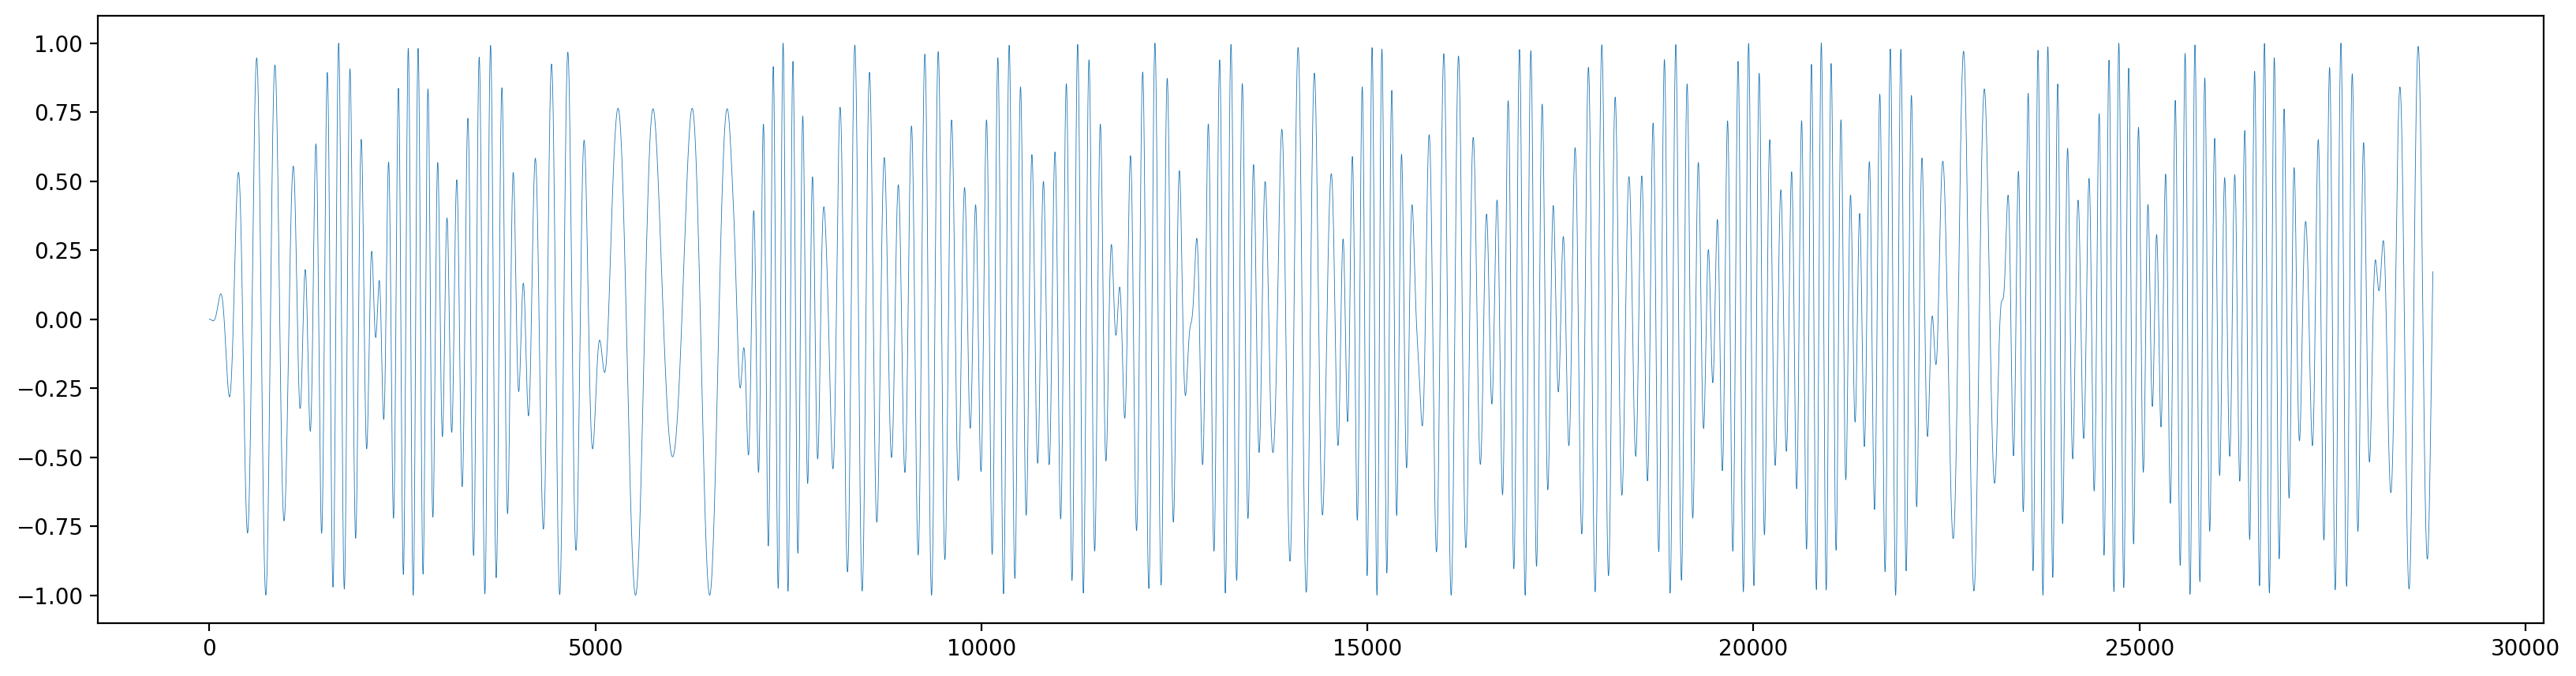

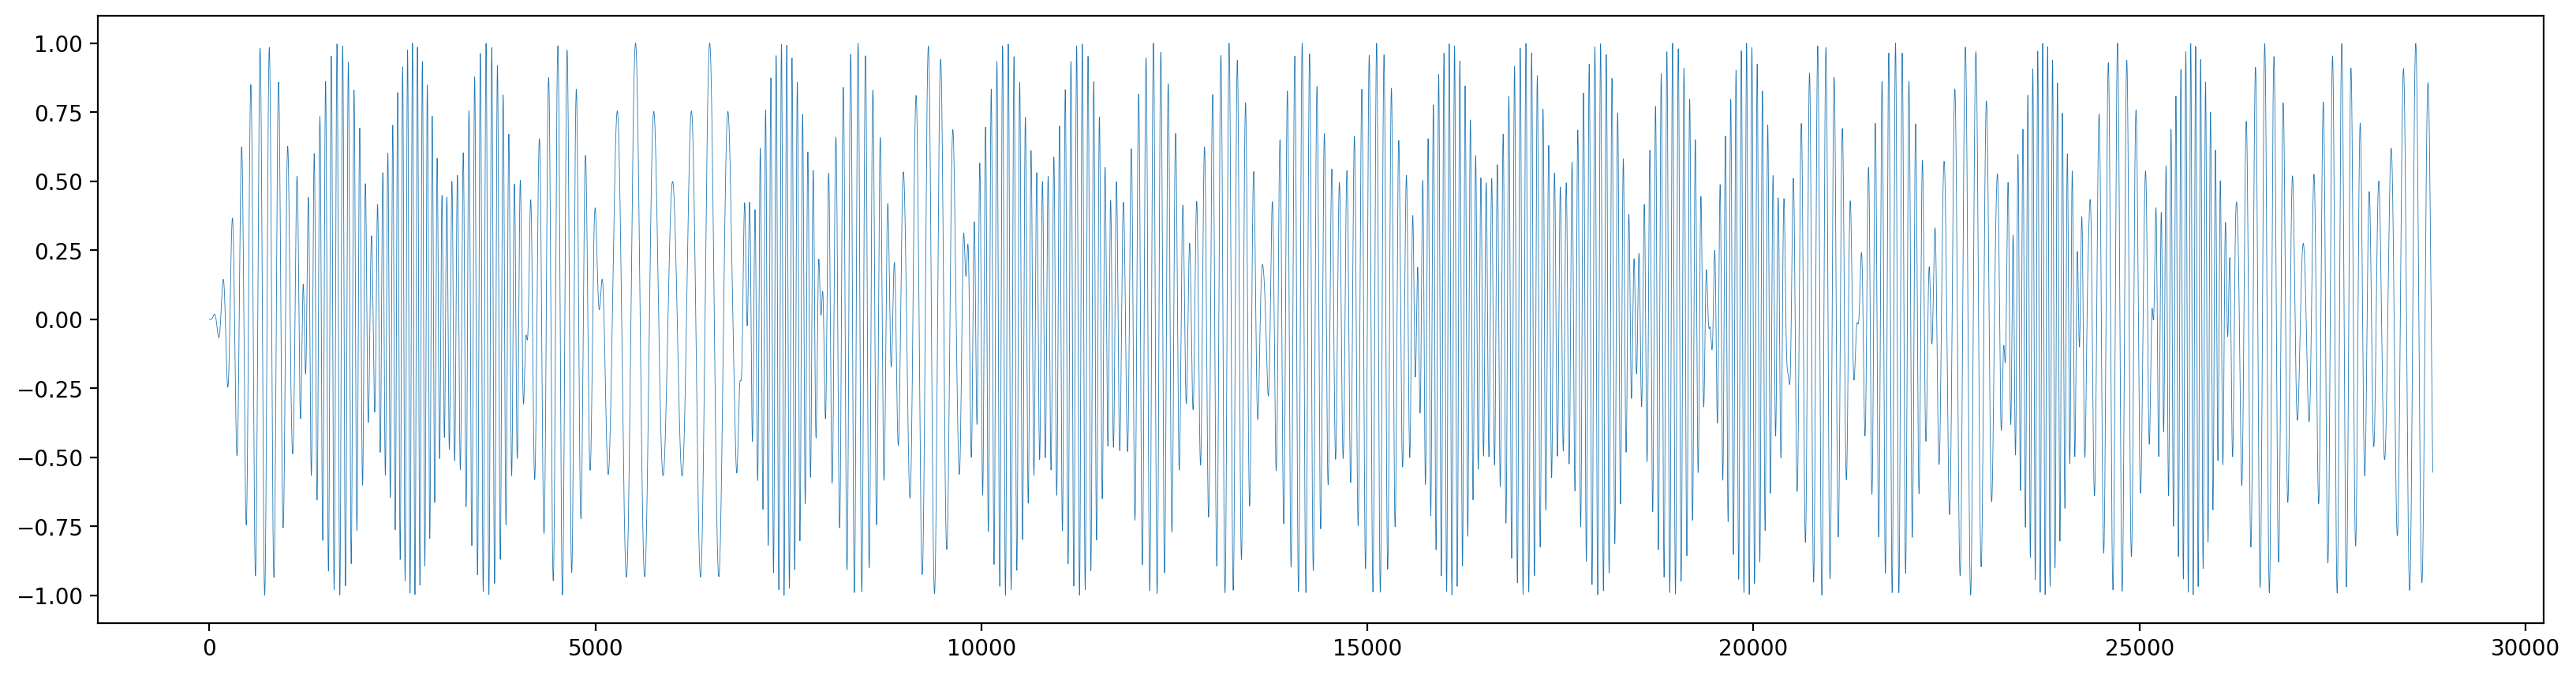

In [10]:
mocap_fps = 240
window_size = 240*6 #corresponding to 10 sec
hop_size = 240*4
tempi_range = np.arange(60,240,15)

tempogram_ab, tempogram_raw, time_axis_seconds, tempo_axis_bpm = compute_tempogram_fourier(both_sensor_onsets, mocap_fps, 
                                                                                        window_length=window_size, hop_size=hop_size, tempi=tempi_range)

dance_beat_tempo_estimation_new(tempogram_ab, tempogram_raw, mocap_fps, 
                                                novelty_length, window_size, hop_size, tempi_range)

# dance_beat_tempo_estimation_weighted(tempogram_ab, tempogram_raw, mocap_fps, 
#                                                 novelty_length, window_size, hop_size, tempi_range)

dance_beat_tempo_estimation_combined([tempogram_ab[0]+tempogram_ab[1]+tempogram_ab[2]], 
                                    [tempogram_raw[0]+tempogram_raw[1]+tempogram_raw[2]], mocap_fps, 
                                    novelty_length, window_size, hop_size, tempi_range)

In [ ]:
j=0
plt.figure(figsize=(100, 12), dpi=100)
plt.plot(time_axis, both_hand_onsets[:,j], linewidth=0.2, color= 'blue')
# plt.plot(time_axis, left_right_combined[:,j], linewidth=0.2, color= 'red')

# plt.plot(time_axis, right_abs_vel[:,j], linewidth=0.5)
# plt.plot(time_axis, left_right_combined[:,j], linewidth=0.5)

# plt.scatter(xkept_onsets/240, right_abs_vel[np.where(right_dir_change[:,j] > 0.5)], color='red', label='Directional Changes', zorder=5, s=4)
# plt.title(f'{segment_name}')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20,6), sharey=False)

# Tempogram X
cax1 = axs[0].pcolormesh(time_axis_seconds, tempo_axis_bpm, tempogram_ab[0], shading='auto', cmap='magma')
axs[0].set_title('X-axis')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Tempo [BPM]')
plt.colorbar(cax1, ax=axs[0], orientation='horizontal', label='Magnitude')

# Tempogram Y
cax2 = axs[1].pcolormesh(time_axis_seconds, tempo_axis_bpm, tempogram_ab[1], shading='auto', cmap='magma')
axs[1].set_title('Y-axis')
axs[1].set_xlabel('Time [s]')
plt.colorbar(cax2, ax=axs[1], orientation='horizontal', label='Magnitude')

# Tempogram Z
cax3 = axs[2].pcolormesh(time_axis_seconds, tempo_axis_bpm, tempogram_ab[2], shading='auto', cmap='magma')
axs[2].set_title('Z-axis')
axs[2].set_xlabel('Time [s]')
plt.colorbar(cax3, ax=axs[2], orientation='horizontal', label='Magnitude')

# Tempogram XYZ
cax3 = axs[3].pcolormesh(time_axis_seconds, tempo_axis_bpm, (tempogram_ab[0]+tempogram_ab[1]+tempogram_ab[2]), shading='auto', cmap='magma')
axs[3].set_title('XYZ-axis')
axs[3].set_xlabel('Time [s]')
plt.colorbar(cax3, ax=axs[3], orientation='horizontal', label='Magnitude')

# plt.suptitle(f'{segment_name} tempograms for the 3 axes')
plt.show()

In [ ]:
# novelty_length = len(left_right_combined[:,0])

tempo_data_maxmethod = dance_beat_tempo_estimation_maxmethod(tempogram_ab, tempogram_raw, mocap_fps, 
                                                   novelty_length, window_size, hop_size, tempi_range)

Aestimated_beat_pulse = tempo_data_maxmethod["estimated_beat_pulse"]
Atempo_curve = tempo_data_maxmethod["tempo_curve"]
Atempo_curve_time_axis = tempo_data_maxmethod["tempo_curve_time_axis"]
Aglobal_tempo_bpm = tempo_data_maxmethod["global_tempo_bpm"]

In [ ]:
tempo_data_weightedkernel = dance_beat_tempo_estimation_weightedkernelmethod(tempogram_ab, tempogram_raw, mocap_fps, 
                                                 novelty_length, window_size, hop_size, tempi_range)


Bestimated_beat_pulse = tempo_data_weightedkernel["estimated_beat_pulse"]
Btempo_curve = tempo_data_weightedkernel["tempo_curve"]
Btempo_curve_time_axis = tempo_data_weightedkernel["tempo_curve_time_axis"]
Bglobal_tempo_bpm = tempo_data_weightedkernel["global_tempo_bpm"]

In [ ]:
tempo_data_combinedtempogram = dance_beat_tempo_estimation_combinedtempogram_method([tempogram_ab[0]+tempogram_ab[1]+tempogram_ab[2]], 
                                                                                    [tempogram_raw[0]+tempogram_raw[1]+tempogram_raw[2]], 
                                                                                    mocap_fps, novelty_length, window_size, hop_size, tempi_range)


Cestimated_beat_pulse = tempo_data_combinedtempogram["estimated_beat_pulse"]
Ctempo_curve = tempo_data_combinedtempogram["tempo_curve"]
Ctempo_curve_time_axis = tempo_data_combinedtempogram["tempo_curve_time_axis"]
Cglobal_tempo_bpm = tempo_data_combinedtempogram["global_tempo_bpm"]



In [ ]:
tt = np.linspace(0, len(Atempo_curve)/240, len(Atempo_curve))
plt.figure(figsize=(40, 6))

plt.plot(tt, Atempo_curve, color = 'blue')
# plt.plot(tt, Ctempo_curve, color = 'red')

plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title('Dynamic Tempo')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(40, 6), dpi=300)
plt.plot(time_axis, Cestimated_beat_pulse, linewidth=0.3, color = 'blue')
# plt.plot(Cestimated_beat_pulse, linewidth=0.3, color = 'red')


plt.vlines(x=np.array([5, 10, 188, 241]), ymin=0.0, ymax=9, color='r', linestyle='dotted', linewidth=0.9)
plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title('Beat Pulse')
plt.grid(True)
plt.show()

In [ ]:
time = np.arange(novelty_length) / mocap_fps
peaks, properties = signal.find_peaks(Cestimated_beat_pulse)  # , prominence=0.02
beat_peaks_sec = time[peaks]

In [ ]:
click_duration = 50  # milliseconds
click_freq = 1200  # Hz
file_name ="suku"
# Generate a single click sound
click = Triangle(click_freq).to_audio_segment(duration=click_duration)

onset_times = beat_peaks_sec  # kept_onsets/240
dN = novelty_length
total_duration = (dN/240)*1000  #  in milliseconds

audio = AudioSegment.silent(duration=total_duration)
for onset in onset_times:
    position = int(onset * 1000)  # Convert onset time to milliseconds
    audio = audio.overlay(click, position=position)

# Export the audio with clicks to a file
audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_combinedmethod_240.wav"), format="wav")